### Load the required libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

### Check for GPU

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')



CUDA is available!  Training on GPU ...


### Choose the transformations on the data

In [3]:
transform = transforms.Compose([
    
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Pad(padding=4,padding_mode='reflect'),
    transforms.RandomCrop(size=32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

### Train test split

In [4]:
train_ds = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_ds = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


### Set the values for hyperparameters
* Might require changes after checking the learning rate plot

In [5]:
bs = 256
lr_low = 1e-6
lr_high = 1e-2
wd = 0.0
Pretrained = True
learning_rate = 0.0001
epochs = 30

### Create iterable object with mini-batches

In [6]:
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False)

### Visualize a Batch of Training Data

In [7]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

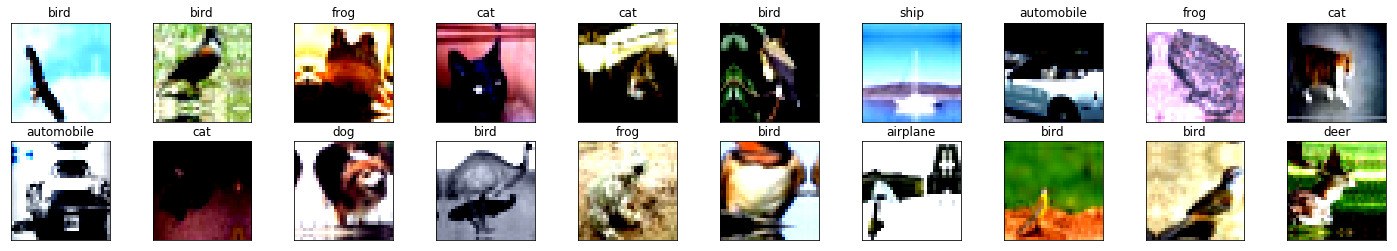

In [8]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


### Check Class imbalance

In [9]:
from collections import defaultdict
classes = defaultdict(int)

classes_list =['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

print('Number of samples in train data %2d \n' % len(train_ds))
for x,y in (train_ds):
    if y not in classes:
        classes[y] = 1
    else: classes[y] = classes[y]+1  
        
for i in range(10):
    print('Class %s : %2d' % (classes_list[i], classes[i]))

Number of samples in train data 50000 

Class airplane : 5000
Class automobile : 5000
Class bird : 5000
Class cat : 5000
Class deer : 5000
Class dog : 5000
Class frog : 5000
Class horse : 5000
Class ship : 5000
Class truck : 5000


### Define Class for the network
Inherit the filters from vgg-16 by setting pretrained = True/False.   
Attach a fully connected layer in the end

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        vgg = models.vgg16_bn(pretrained=Pretrained)
        layers = list(vgg.children())[0][:31]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.linear1 = nn.Linear(512,10)

    def forward(self,x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0],-1)
        x = self.bn1(x)
        x = self.linear1(x)
        return x
    
    

### Instantiate a Class object and move to GPU

In [27]:
net = Net()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    net.cuda()
    

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/jupyter/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:05<00:00, 108194958.89it/s]


In [43]:
net.parameters

<bound method Module.parameters of Net(
  (top_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14):

In [44]:

optimizer = optim.SGD([
    {'params': net.top_model[0:10].parameters(), 'lr': learning_rate/10, 'momentum': 0.9 },
    {'params': net.top_model[10:31].parameters(), 'lr ':learning_rate/3 , 'momentum':0.9 },
    {'params': net.linear1.parameters()},
    {'params': net.bn1.parameters()},  
], lr=learning_rate, momentum=0.9 )

### Helper Functions

In [49]:
def correct(preds, targs):
    preds = torch.max(preds, dim=1)[1]
    return (preds==targs).float().sum()

def get_optimizer(model, lr = 0.1,  momentum=0.9 ):
    """
    Initialize optimizer with the learning rate passed
    """
    optim = torch.optim.SGD([
    {'params': model.top_model[0:10].parameters(), 'lr': lr/10, 'momentum': 0.9 },
    {'params': model.top_model[10:31].parameters(), 'lr ':lr/3 , 'momentum':0.9 },
    {'params': model.linear1.parameters()},
    {'params': model.bn1.parameters()},  
], lr=lr, momentum=0.9 )
    return optim

def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))


### Learning Rate Finder
* Choose max_learning rate that is 0.1*learningrate that gives lowest loss

In [15]:
def LR_range_finder(train_on_gpu,model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = "mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            if train_on_gpu:
                x, y = x.cuda().float(), y.cuda().long()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1     
    load_model(model, str(p))
    return lrs, losses

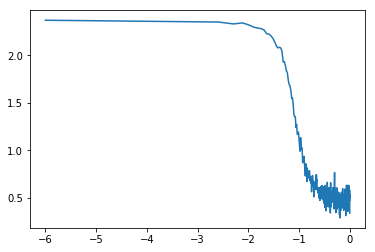

In [47]:
lrs, losses = LR_range_finder(train_on_gpu,net, train_loader, lr_low=lr_low, lr_high=1)
plt.plot([np.log10(l) for l in lrs], losses)
plt.show()


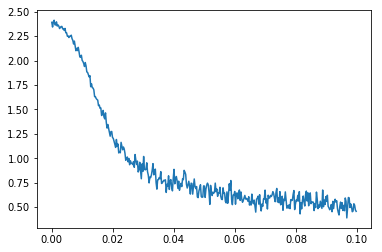

In [17]:
plt.plot(lrs, losses)
plt.show()

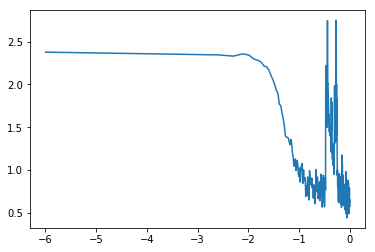

In [18]:
lrs, losses = LR_range_finder(train_on_gpu,net, train_loader, lr_low=lr_low, lr_high=1)
plt.plot([np.log10(l) for l in lrs], losses)
plt.show()


### Function to train the network

In [19]:
def train(train_on_gpu,model, train_dl, valid_dl, epochs=4, name = str('temp')):
    """
    Train the given network, save the model weights when accuracy is lowest, return average loss across epochs
    """
    acc = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        """
        if i % 10 == 0:
            torch.save(model.state_dict(), 'Resnet_1.pth')
            
        """
            
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model)
            batch = y.shape[0]
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                x, y = x.cuda().float(), y.cuda().long()
            # forward pass: compute predicted outputs by passing inputs to the model
            out = model(x)
            # calculate the batch loss
            loss = F.cross_entropy(out, y)
            # set the gradients for tensors to zero to prevent gradient accumulation
            optim.zero_grad()
            # backward pass
            loss.backward()
            # Update parameters
            optim.step()
            # update train loss and total images processes
            total += batch
            sum_loss += batch*(loss.item())
            
        print("train loss", sum_loss/total)
        # Save the model weights which has lowest validation accuracy
        val_loss, accuracy = val_metrics(train_on_gpu , model, valid_dl)
        if accuracy > acc:
            torch.save(model.state_dict(), name)
        acc = accuracy
            
    return sum_loss/total


### Function to find the performance on validation set

In [20]:
def val_metrics(train_on_gpu , model, valid_dl):
    """
    Calculate the accuracy on validation set with weights trained above
    """
    model.eval()
    total = 0
    sum_loss = 0
    total_correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        if train_on_gpu:
            x, y = x.cuda().float(), y.cuda().long()
        out = model(x)
        total_correct += correct(out, y)
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    
    print("val loss and accuracy", sum_loss/total, total_correct/total)
    return (sum_loss/total, total_correct/total)

### Function to get performance per class

In [21]:
def val_metrics_new(train_on_gpu , model, valid_dl,batch_size):
    """
    Function that returns class wise accuracy and validation scores
    """
    from sklearn.metrics import classification_report
    # track test loss
    test_loss = 0.0
    total_predictions = []
    total_target = []
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    j = 0
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

    model.eval()
    # iterate over test data
    for data, target in valid_dl:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = F.cross_entropy(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)   
        total_predictions.extend(pred)
        total_target.extend(target.data.view_as(pred))
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct =  np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        j = j+batch_size
        if j > 10000: batch_size = batch_size - (j - 10000)
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
            
    ### Print per class accuracy

    print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    

    ### Print Fscore
    print(classification_report([int(i) for i in total_target], [int(i) for i in total_predictions]))
    
    

### GET SET TRAIN !

In [50]:
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, net, train_loader, test_loader, epochs = 10, name = str('temp'))
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.6962033276844025
val loss and accuracy 0.4560991886138916 tensor(0.8430, device='cuda:0')
train loss 0.3694140290927887
val loss and accuracy 0.4249672185897827 tensor(0.8491, device='cuda:0')
train loss 0.28905691011428836
val loss and accuracy 0.45246465492248533 tensor(0.8503, device='cuda:0')
train loss 0.2380810591697693
val loss and accuracy 0.423038626241684 tensor(0.8517, device='cuda:0')
train loss 0.20368919637680052
val loss and accuracy 0.3642381422996521 tensor(0.8773, device='cuda:0')
train loss 0.17279252101898193
val loss and accuracy 0.3858684191703796 tensor(0.8732, device='cuda:0')
train loss 0.15282254102945328
val loss and accuracy 0.31265480298995973 tensor(0.8951, device='cuda:0')
train loss 0.1310425632429123
val loss and accuracy 0.3490194387435913 tensor(0.8867, device='cuda:0')
train loss 0.11512915175437927
val loss and accuracy 0.37336863498687745 tensor(0.8820, device='cuda:0')
train loss 0.10350858570337296
val loss and accuracy 0.31568998537

In [51]:
#torch.save(net.state_dict(), 'vgg16_sgdonly.pth')
model = Net().cuda()
model.load_state_dict(torch.load('temp'))

### Get the per class validation performance

In [52]:
val_metrics(train_on_gpu, model,test_loader)
print('\n')
val_metrics_new(train_on_gpu, model,test_loader,bs)

val loss and accuracy 0.31361553654670715 tensor(0.8998, device='cuda:0')


Test Loss: 0.311872

Test Accuracy of airplane: 91% (910/1000)
Test Accuracy of automobile: 94% (943/1000)
Test Accuracy of  bird: 90% (903/1000)
Test Accuracy of   cat: 77% (773/1000)
Test Accuracy of  deer: 90% (906/1000)
Test Accuracy of   dog: 82% (821/1000)
Test Accuracy of  frog: 93% (932/1000)
Test Accuracy of horse: 89% (897/1000)
Test Accuracy of  ship: 94% (943/1000)
Test Accuracy of truck: 95% (952/1000)

Test Accuracy (Overall): 89.80% (8980/10000)
             precision    recall  f1-score   support

          0       0.92      0.91      0.91      1000
          1       0.95      0.94      0.95      1000
          2       0.84      0.90      0.87      1000
          3       0.81      0.77      0.79      1000
          4       0.89      0.91      0.90      1000
          5       0.83      0.82      0.82      1000
          6       0.94      0.93      0.94      1000
          7       0.96      0.90  